SL at 2024-12-31 17:30:00+00:00  |  PnL: -10.00 USDT  | Losing Trade Count Number: 1
Entry: 195.82  | SL: 195.82  |  TP: 199.82
TP at 2025-01-02 00:30:00+00:00  |  PnL: 30.00 USDT  | Pro Trade Count Number: 1
Entry: 191.89  | SL: 191.89  |  TP: 196.04
SL at 2025-01-03 01:00:00+00:00  |  PnL: -21.40 USDT  | Losing Trade Count Number: 2
Entry: 208.20  | SL: 206.92  |  TP: 212.04
SL at 2025-01-03 13:15:00+00:00  |  PnL: -20.97 USDT  | Losing Trade Count Number: 3
Entry: 214.59  | SL: 212.74  |  TP: 220.13
SL at 2025-01-04 08:45:00+00:00  |  PnL: -10.28 USDT  | Losing Trade Count Number: 4
Entry: 215.32  | SL: 215.32  |  TP: 221.02
SL at 2025-01-05 01:30:00+00:00  |  PnL: -10.28 USDT  | Losing Trade Count Number: 5
Entry: 216.28  | SL: 216.28  |  TP: 218.86
SL at 2025-01-06 13:15:00+00:00  |  PnL: -20.55 USDT  | Losing Trade Count Number: 6
Entry: 216.98  | SL: 215.91  |  TP: 220.18
SL at 2025-01-06 14:15:00+00:00  |  PnL: -10.07 USDT  | Losing Trade Count Number: 7
Entry: 217.61  | SL: 21

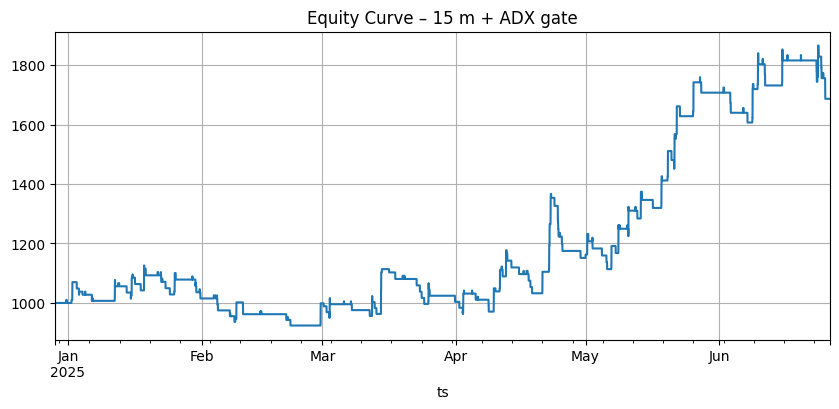

                         exit        pnl type
0   2024-12-31 17:30:00+00:00 -10.000000   SL
1   2025-01-02 00:30:00+00:00  60.000000   TP
2   2025-01-03 01:00:00+00:00 -21.400000   SL
3   2025-01-03 13:15:00+00:00 -20.972000   SL
4   2025-01-04 08:45:00+00:00 -10.276280   SL
..                        ...        ...  ...
170 2025-06-24 15:30:00+00:00 -36.565271   SL
171 2025-06-24 17:15:00+00:00 -35.833965   SL
172 2025-06-25 03:00:00+00:00 -17.558643   SL
173 2025-06-25 13:30:00+00:00 -35.117286   SL
174 2025-06-25 14:15:00+00:00 -34.414940   SL

[175 rows x 3 columns]
Win-rate      : 19.43%
Expectancy (R): -11.88
Max DD %      : -7.59%
Total Profitable Trades: 34


In [1]:
# pip install ccxt pandas numpy matplotlib
import ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ────────── CONFIG ───────────────────────────────────────────────────
PAIR          = "SOL/USDT"
TF            = "15m"
LOOKBACK_D    = 180                  # history
RISK_PCT      = 0.02                 # 2 % risk
ATR_MULT_SL   = 1.5
TP_MULT       = 3
PARTIAL_R1    = 1                    # scale-out half at +1 R
DAILY_DD_CAP  = 0.04    
TREND_ADX   = 20          # min ADX for either side
TRAIL_MULT  = 2           # ATR trail for the second half             # -4 R stop-for-day

SESSION_H1, SESSION_H2 = 12, 23      # 12:00–23:59 UTC
VOL_SPIKE     = 1.5
ADX_THR   = 15          # loose but meaningful
VOL_MULT  = 1.3         # a bit looser than 1.5
EMA_FILTER    = True                 # 1-h EMA-50 trend

# NEW: ADX gate
ADX_THR       = 5                  # textbook “trending” level

# ────────── FETCH DATA ───────────────────────────────────────────────
ex      = ccxt.bybit()
since   = ex.milliseconds() - LOOKBACK_D * 86_400_000
candles = []
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    candles += chunk; since = chunk[-1][0] + 1

df = (pd.DataFrame(candles, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ────────── INDICATORS ───────────────────────────────────────────────
# ATR14
df["atr"] = (
    pd.concat([df.h - df.l,
               (df.h - df.c.shift()).abs(),
               (df.l - df.c.shift()).abs()], axis=1)
        .max(axis=1).rolling(14).mean()
)

# EMAs
df["ema7"]   = df.c.ewm(span=7).mean()
df["ema14"]  = df.c.ewm(span=14).mean()
df["ema28"]  = df.c.ewm(span=28).mean()

# Compression metrics
df["ema_spread"]      = (df.ema7 - df.ema28).abs()
df["atr_norm_spread"] = df.ema_spread / df.atr

# Slopes
df["slope7"]  = df.ema7.diff(3)
df["slope28"] = df.ema28.diff(3)

# MACD
macd_fast = df.c.ewm(span=12).mean()
macd_slow = df.c.ewm(span=26).mean()
df["macd"]   = macd_fast - macd_slow
df["signal"] = df.macd.ewm(span=9).mean()

# 1️⃣  Indicators (only changes shown)
df["vol20"]   = df.v.rolling(20).mean()
df["vol_gate"] = df.v / df.vol20      # save a division later

# ADX 14
tr = np.maximum.reduce([
        df.h - df.l,
        (df.h - df.c.shift()).abs(),
        (df.l - df.c.shift()).abs()
     ])
plus_dm  = np.where(df.h.diff() > df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff() > df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr, index=df.index).rolling(14).sum()
plus_di  = 100 * pd.Series(plus_dm, index=df.index).rolling(14).sum() / tr_n
minus_di = 100 * pd.Series(minus_dm, index=df.index).rolling(14).sum() / tr_n
dx       = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
df["adx"] = dx.rolling(14).mean()

# 1-hour trend filter
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"] = h1.close.ewm(span=50).mean()

# ────────── BACK-TEST LOOP ───────────────────────────────────────────
equity, pos, trades = 1_000.0, None, []
equity_curve = []
day_pnl_R, current_day = 0.0, None
prof_trade_count = 0
losing_strade_count = 0


for i in range(30, len(df)):
    bar, prev = df.iloc[i], df.iloc[i-1]
    now_day   = bar.name.date()

    # Reset daily loss counter
    if current_day != now_day:
        day_pnl_R, current_day = 0.0, now_day

    # ── Manage open position ──────────────────────────────────────
    if pos:
        if bar.l <= pos["sl"]:                      # stop-loss
            equity += -pos["risk"];  day_pnl_R -= 1
            trades.append({"exit": bar.name, "pnl": -pos["risk"], "type": "SL"})
            losing_strade_count += 1
            print(f"SL at {bar.name}  |  PnL: {-pos['risk']:.2f} USDT  | Losing Trade Count Number: {losing_strade_count}")
            print (f"Entry: {pos['entry']:.2f}  | SL: {pos['sl']:.2f}  |  TP: {pos['tp']:.2f}")
            pos = None

        elif (not pos["half"] and                   # +1 R partial
              (bar.h - pos["entry"]) >= pos["risk_per_unit"]):
            equity += 0.5 * pos["risk"]
            pos["sl"] = pos["entry"]; pos["risk"] *= 0.5; pos["half"] = True

        elif bar.h >= pos["tp"]:                    # +3 R full TP
            equity += pos["risk"] * (TP_MULT / (pos["half"] and 0.5 or 1))
            day_pnl_R += TP_MULT - (pos["half"] and 1 or 0)
            trades.append({"exit": bar.name,
                           "pnl":  pos["risk"] * TP_MULT/(pos['half'] and 0.5 or 1),
                           "type": "TP"})
            prof_trade_count +=  1
            print(f"TP at {bar.name}  |  PnL: {pos['risk'] * TP_MULT:.2f} USDT  | Pro Trade Count Number: {prof_trade_count}")
            print (f"Entry: {pos['entry']:.2f}  | SL: {pos['sl']:.2f}  |  TP: {pos['tp']:.2f}")
            pos = None

    # ── Entry checks ──────────────────────────────────────────────
    if pos is None:
        hour_ok = SESSION_H1 <= bar.name.hour <= SESSION_H2
        dd_ok = True
        trend_ok = True
        if EMA_FILTER:
            h1_idx = h1.index.get_loc(bar.name.floor("1H"))
            trend_ok = h1.close.iloc[h1_idx] > h1.ema50.iloc[h1_idx]

        # Compression-breakout core
        compressed   = prev.atr_norm_spread < .30
        expanding    = bar.atr_norm_spread  > prev.atr_norm_spread
        slope_ok     = (bar.slope7 > 0) and (bar.slope28 > 0)
        adx_ok       = bar.adx > ADX_THR                # NEW filter
        vol_ok       = bar.v > VOL_SPIKE * bar.vol20
        macd_ok      = prev.macd < prev.signal < bar.macd
        ema_stack    = bar.c > bar.ema7 > bar.ema14 > bar.ema28
        vol_ok  = bar.vol_gate > VOL_MULT

        if hour_ok and dd_ok and trend_ok and adx_ok and \
               expanding and slope_ok and vol_ok and ema_stack:

            stop_dist = ATR_MULT_SL * bar.atr
            risk_usdt = equity * RISK_PCT
            pos = dict(entry=bar.c,
                       sl=bar.c - stop_dist,
                       tp=bar.c + TP_MULT * stop_dist,
                       risk=risk_usdt,
                       risk_per_unit=stop_dist,
                       half=False)

    equity_curve.append(equity)

# ────────── RESULTS ───────────────────────────────────────────────
import matplotlib.pyplot as plt
curve = pd.Series(equity_curve, index=df.index[-len(equity_curve):])
t_df  = pd.DataFrame(trades)

print(f"Trades: {len(t_df)}  |  Win-rate: {(t_df.type=='TP').mean():.1%}  "
      f"|  Final balance: ${equity:,.0f}")
curve.plot(title="Equity Curve – 15 m + ADX gate", figsize=(10,4), grid=True)
plt.show()
print(t_df)
print(f"Win-rate      : {(t_df.type=='TP').mean():.2%}")
print(f"Expectancy (R): {t_df.pnl.sum() / t_df.pnl.abs().mean():.2f}")
print(f"Max DD %      : {(min(equity_curve) - 1000)/1000:.2%}")
print(f"Total Profitable Trades: {prof_trade_count}")
